<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

aim: fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

> Indented block



The pretrained BERT model :  [here](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

## Task 2: Setup your TensorFlow and Colab Runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia- # util for checking GPU: Tesla T4

/bin/bash: nvidia-: command not found


### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
# !pip install -q tensorflow==2.3.0 # at least 

2.8.2


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git # to mnodels directory 

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# restart the runtime afterwards

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# dataset
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression = 'zip', low_memory = False)

df.shape

(1306122, 3)

In [ ]:
# last 20 rows
df.tail(20) # quid, question_text, target

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


In [ ]:
df.target.plot(kind = 'hist', title = 'Target distribution'); 
# highly imbalenced dataset : majority are sincere
# solve by stratified sampling

ImportError: ignored

<Figure size 432x288 with 1 Axes>

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [ ]:
# training, validation set 
train_df, remaining = train_test_split(df, random_state = 42, 
                                       train_size = 0.0075, # time limit on project
                                       stratify = df.target.values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.00075, stratify = remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
# return python iterable dataset obj
with tf.device('/cpu:0'): 
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1): # look at 1st entry. demo: can use for loop. 
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1] # Label categories. 0 = sincere. 1 = insincere
max_seq_length = 128  # maximum length of (token) input sequences
train_batch_size = 32 


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = True) # default = F

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
a = tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')
print(a)
# convert token to id 
print(tokenizer.convert_tokens_to_ids(a))

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']
[7632, 29623, 2129, 2024, 2017, 2725, 29632]


## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label
# 0, 1, 2 : prepended to start seq, appended to end of seq

def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None, 
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label], 
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask' :input_mask,
      'input_type_ids' : segment_ids
  }
  return (x, label_id)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE) # optimise the best parallel calls. can be customised
  .shuffle(1000) # only on training 
  .batch(32, drop_remainder= True) #remaining barth 
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder= True) 
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
# pooled: entire embedding of input sequence 
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name = 'input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name = 'input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name = 'input_type_ids')
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  #preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  #encoder_inputs = preprocessor(input_q)
  #encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable =True)
  #outputs = encoder(encoder_inputs)
  #pooled_output = outputs["pooled_output"]     
  #sequence_output = outputs["sequence_output"]  

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) # drop regularisation
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop) # 2-class. higher than threshold -> +ve
  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

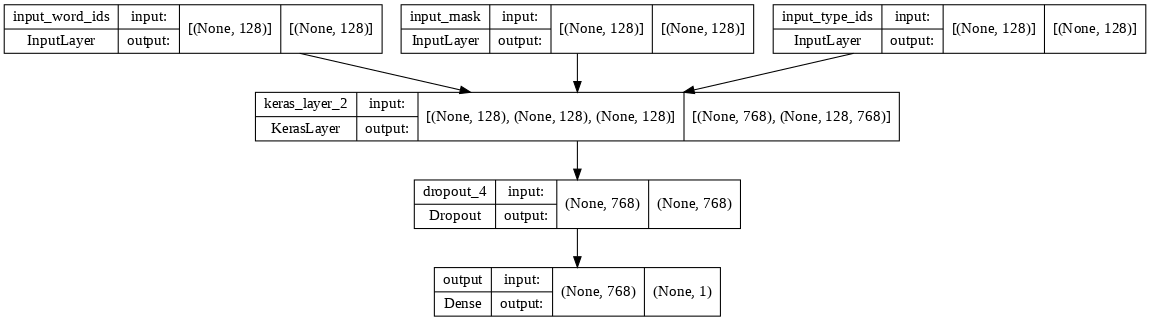

In [ ]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76) # entire transformer model to single input layer

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data, 
                    validation_data = valid_data, 
                    epochs = epochs,
                    verbose = 1)    # generate ouput n

Epoch 1/4
  2/306 [..............................] - ETA: 4:38:16 - loss: 0.7134 - binary_accuracy: 0.4531

## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'binary')

In [ ]:
sample_example = ['sentence 1']
test_data = tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.8 #between 0, 1
['Insincere' if pred>= threshold else 'Sincere' for pred in preds]